In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-09-30 22:17:00--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71,53K  --.-KB/s    in 0,1s    

2022-09-30 22:17:01 (737 KB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [82]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (mutual_info_score, 
                             accuracy_score,
                             mean_squared_error, 
                             roc_auc_score, 
                             auc)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_extraction import DictVectorizer

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
SEED = 1

In [3]:
df = pd.read_csv('AER_credit_card_data.csv')

In [4]:
df

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


In [6]:
df.card = df.card.map({'yes': 1, 'no': 0})

In [8]:
df_train_val, df_test = train_test_split(df, test_size=.2, random_state=SEED)
df_train_val.shape, df_test.shape

((1055, 12), (264, 12))

In [9]:
df_train, df_val = train_test_split(
    df_train_val, 
    test_size=df_test.shape[0] / df_train_val.shape[0], 
    random_state=SEED
)
df_train.shape, df_val.shape

((791, 12), (264, 12))

In [22]:
target = 'card'

# Q1

In [39]:
# Which numerical variable (among the following 4) has the highest AUC?
four_feats = [
    'reports',
    'dependents',
    'active',
    'share']

In [21]:
num_feats = df_train.columns[df_train.dtypes != 'object']
num_feats = num_feats[num_feats != target]
num_feats

Index(['reports', 'age', 'income', 'share', 'expenditure', 'dependents',
       'months', 'majorcards', 'active'],
      dtype='object')

In [42]:
feat_imp = dict()
for f in num_feats:
    ras = roc_auc_score(df_train[target], df_train[f])
    if ras < 0.5:
        ras = roc_auc_score(df_train[target], -df_train[f])
    print(f, ras)
    if f in four_feats:
        feat_imp[f] = ras

reports 0.7166629860689376
age 0.5240020979407055
income 0.5908049467233478
share 0.989183643423692
expenditure 0.991042345276873
dependents 0.5327757227773791
months 0.5294217780967629
majorcards 0.5343859842838476
active 0.6043173411362006


In [43]:
sorted(feat_imp.items(), key=lambda x: x[1], reverse=True)

[('share', 0.989183643423692),
 ('reports', 0.7166629860689376),
 ('active', 0.6043173411362006),
 ('dependents', 0.5327757227773791)]

### Training the model

In [44]:
features = [
    "reports", "age", "income", "share", "expenditure", "dependents",
    "months", "majorcards", "active", "owner", "selfemp"
]

In [48]:
df_train[features].head(2)

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner,selfemp
1105,3,40.50000,4.0128,0.000299,0.0,1,12,1,17,no,no
431,1,32.33333,6.0000,0.000200,0.0,4,18,1,4,yes,no


In [55]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[features].to_dict(orient='records')
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [56]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [57]:
model.fit(X_train, df_train[target])

LogisticRegression(max_iter=1000, solver='liblinear')

In [58]:
val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [61]:
y_pred = model.predict_proba(X_val)[:,1]

In [65]:
y_val = df_val[target]

# Q2

In [64]:
round(roc_auc_score(df_val[target], y_pred), 3)

0.995

# Q3

In [67]:
scores = []
for t in np.linspace(0, 1, 101):
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()

    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [68]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,211,53,0,0,0.799242,1.000000
1,0.01,211,34,0,19,0.861224,1.000000
2,0.02,211,31,0,22,0.871901,1.000000
3,0.03,211,24,0,29,0.897872,1.000000
4,0.04,211,22,0,31,0.905579,1.000000
...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,1.000000,0.966825
97,0.97,203,0,8,53,1.000000,0.962085
98,0.98,203,0,8,53,1.000000,0.962085
99,0.99,202,0,9,53,1.000000,0.957346


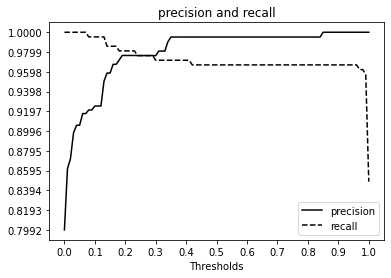

In [73]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.precision, color='black', linestyle='solid', label='precision')
plt.plot(df_scores.threshold, df_scores.recall, color='black', linestyle='dashed', label='recall')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(min(df_scores.precision.min(), df_scores.recall.min()), 1, 11))

plt.xlabel('Thresholds')
plt.title('precision and recall')

plt.show()

0.3

# Q4

In [76]:
df_scores['f1'] = 2 * df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall'])
df_scores.sort_values('f1', ascending=False)

,threshold,tp,fp,fn,tn,precision,recall,f1
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
...,...,...,...,...,...,...,...,...
3,0.03,211,24,0,29,0.897872,1.000000,0.946188
2,0.02,211,31,0,22,0.871901,1.000000,0.931567
1,0.01,211,34,0,19,0.861224,1.000000,0.925439
100,1.00,179,0,32,53,1.000000,0.848341,0.917949


In [81]:
round(df_scores.sort_values('f1', ascending=False).iloc[0]['threshold'], 1)

0.4

# Q5

In [95]:
def train_model(X_df, y, features, C=1.0):
    X_dict = X_df[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(X_dict)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)
    
    return dv, model

In [89]:
def predict(X_df, features, dv, model):
    X_dict = X_df[features].to_dict(orient='records')
    X = dv.transform(X_dict)
    
    return model.predict_proba(X)[:, 1]

In [91]:
aucs = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_val):
    kf_X_train = df_train_val.iloc[train_idx]
    kf_y_train = kf_X_train[target] 
    
    kf_X_val = df_train_val.iloc[val_idx]
    kf_y_val = kf_X_val[target]
    
    dv, model = train_model(kf_X_train, kf_y_train, features)
    kf_y_pred = predict(kf_X_val, features, dv, model)
    
    ras = roc_auc_score(kf_y_val, kf_y_pred)
    aucs.append(ras)

In [94]:
round(np.std(aucs), 3)

0.003

# Q6

In [96]:
aucs = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for C in [0.01, 0.1, 1, 10]:
    for train_idx, val_idx in kfold.split(df_train_val):
        kf_X_train = df_train_val.iloc[train_idx]
        kf_y_train = kf_X_train[target] 

        kf_X_val = df_train_val.iloc[val_idx]
        kf_y_val = kf_X_val[target]

        dv, model = train_model(kf_X_train, kf_y_train, features, C=C)
        kf_y_pred = predict(kf_X_val, features, dv, model)

        ras = roc_auc_score(kf_y_val, kf_y_pred)
        aucs.append((C, ras))

In [100]:
df_q6 = pd.DataFrame(aucs)
df_q6.columns = ['C', 'auc']

In [117]:
df_q6.groupby('C').agg({'auc':['mean','std']}).round(3)#.sort_values('auc', ascending=False)

auc       
        mean    std
C                  
0.01   0.992  0.006
0.10   0.995  0.004
1.00   0.996  0.003
10.00  0.996  0.003

C = 1